# Genome sequences and genome features

In our lecture on August 31st 2015, we discussed how we conceptualize molecules of genomic DNA.
Rather than a detailed representation of its various biochemical properties and physical structure, we use a simple abstract representation of the information the DNA contains: a character string.
Features of interest within the DNA (such as genes) correspond to particular substrings of our string representation.
We discussed the [Fasta format](https://en.wikipedia.org/wiki/FASTA_format) for storing nucleotide or amino acid sequences, and we discussed the [GFF3 format](http://www.sequenceontology.org/gff3.shtml) for annotating features within a sequence.

**The take home message of the day**: although DNA is a complex and fascinating molecule, most of the computation we do in genome biology can be reduced to string and interval processing.

## Practical

We spent a few minutes on a practical getting our hands dirty with a simple example.
Sequences and annotations used in class are available on GitHub [here](https://github.com/standage/smel-aug2015).
If you're curious, the data is from the bacterium [*Sinorhizobium meliloti*](https://en.wikipedia.org/wiki/Sinorhizobium_meliloti), an nitrogen-fixing microbe found in the roots of some plants.

Below are the examples we ran in class.
You saw me edit the code in place, and if you're using the IPython/Jupyter notebook, that's often how you'll want to work.
However, I will duplicate some of the code blocks several times to show how we built up the example.

### Gene annotations (GFF3 format)

In [1]:
%matplotlib inline

# Take care of all our import statements first
import matplotlib.pyplot as plt
import numpy

In [2]:
# Example 1: read the whole sample file line by line
filehandle = open('sample.gff3', 'r')
for line in filehandle:
    print line

##gff-version   3

##sequence-region   Chromosome 1 3654135

Chromosome	ena	gene	478	1299	.	+	.	ID=gene:SMc02793;biotype=protein_coding;description=Conserved hypothetical protein;version=1

Chromosome	ena	transcript	478	1299	.	+	.	ID=transcript:CAC41388;Parent=gene:SMc02793;Dbxref=ENA_FEATURE_PROTEIN:AL591688.1:CDS:478..1299,ENA_FEATURE_TRANSCRIPT:AL591688.1:CDS:478..1299,IntEnz:2.7.11.32,IntEnz:2.7.4.27,STRING:266834.SMc02793,UniParc:UPI00000CB8E8,UniProtKB:Q92TF2,NCBI_GP:CAC41388.1;Ontology_term=GO:GO:0004674,GO:GO:0005524,GO:GO:0006470,GO:GO:0016776,GO:GO:0043531;biotype=protein_coding;version=1

Chromosome	ena	exon	478	1299	.	+	.	Parent=transcript:CAC41388;Name=CAC41388-1;constitutive=1;rank=1

Chromosome	ena	CDS	478	1299	.	+	0	Parent=transcript:CAC41388

###

Chromosome	ena	gene	1347	1946	.	+	.	ID=gene:SMc02792;biotype=protein_coding;description=Septum formation protein Maf;version=1

Chromosome	ena	transcript	1347	1946	.	+	.	ID=transcript:CAC41389;Parent=gene:SMc02792;Dbxref=ENA_

In [3]:
# Example 2: pull out the gene features, ignore all others
fh = open('sample.gff3', 'r')
for line in fh:
    # This is a crude test, but it works in most cases. If you were
    # writing production code you would want to use a robust well-
    # tested GFF3 parser.
    if '\tgene\t' in line:
        print line.rstrip()  # Add the .rstrip() to strip whitespace
                             # at the end of the line

Chromosome	ena	gene	478	1299	.	+	.	ID=gene:SMc02793;biotype=protein_coding;description=Conserved hypothetical protein;version=1
Chromosome	ena	gene	1347	1946	.	+	.	ID=gene:SMc02792;biotype=protein_coding;description=Septum formation protein Maf;version=1
Chromosome	ena	gene	1939	2799	.	+	.	ID=gene:SMc02791;Name=aroE1;biotype=protein_coding;description=Probable shikimate 5-dehydrogenase;version=1
Chromosome	ena	gene	2796	3380	.	+	.	ID=gene:SMc02790;Name=coaE;biotype=protein_coding;description=Dephospho-CoA kinase;version=1
Chromosome	ena	gene	3574	4302	.	+	.	ID=gene:SMc02789;Name=dnaQ;biotype=protein_coding;description=Probable DNA polymerase III%2C epsilon chain;version=1


In [4]:
# Example 3: calculate length of each gene feature
fh = open('sample.gff3', 'r')
for line in fh:
    if '\tgene\t' in line:
        values = line.split('\t')
        start = int(values[3])  # fourth value is the start coordinate
        end = int(values[4])    # fifth value is the end coordinate
        genelength = end - start + 1  # discrete interval length
        print genelength

822
600
861
585
729


In [5]:
# Example 4: store gene lengths in an array/list
genelengths = list()
fh = open('sample.gff3', 'r')
for line in fh:
    if '\tgene\t' in line:
        values = line.split('\t')
        start = int(values[3])
        end = int(values[4])
        genelength = end - start + 1
        genelengths.append(genelength)
print genelengths

[822, 600, 861, 585, 729]


In [6]:
# Example 5: now, repeat for the entire data set
#---------------------------------------------------------------------
lengths = list()
fh = open('s_meliloti.gff3', 'r')
for line in fh:
    if '\tgene\t' in line:
        values = line.split('\t')
        start = int(values[3])
        end = int(values[4])
        length = end - start + 1
        lengths.append(length)
print 'S. meliloti has %d genes' % len(lengths)

S. meliloti has 6265 genes


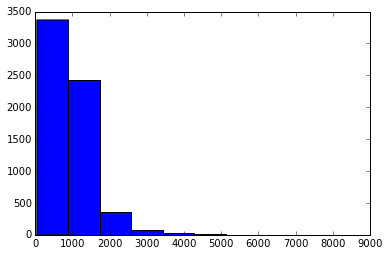

In [7]:
# Example 6: plot the gene length distribution
plot = plt.hist(lengths)

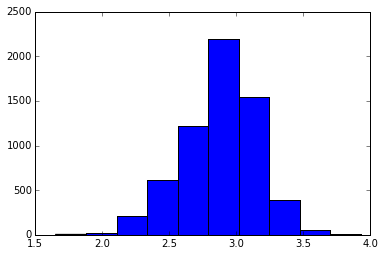

In [8]:
# Example 7: plot the log-transformed length distribution
plot = plt.hist(numpy.log10(lengths))

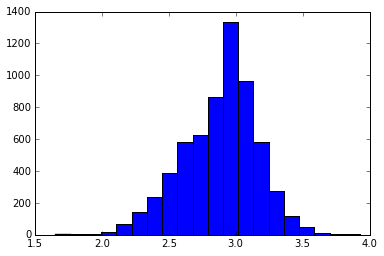

In [9]:
# Example 8: increase the resolution of the histogram
plot = plt.hist(numpy.log10(lengths), bins=20)

### DNA sequences (Fasta format)

In [10]:
def parse_fasta(data):
    """
    Read DNA, RNA, or protein sequences in Fasta format.

    This generator function yields a tuple containing a defline and a sequence
    for each record in the Fasta data. Stolen shamelessly from
    http://stackoverflow.com/a/7655072/459780.
    """
    name, seq = None, []
    for line in data:
        line = line.rstrip()
        if line.startswith('>'):
            if name:
                yield (name, ''.join(seq))
            name, seq = line, []
        else:
            seq.append(line)
    if name:
        yield (name, ''.join(seq))

In [11]:
for defline, sequence in parse_fasta(open('s_meliloti.fa', 'r')):
    print 'This is a defline:      %s' % defline
    print 'This is the seqid:      %s' % defline[1:].split()[0]
    print 'First 50 nucleotides:   %s' % sequence[0:50]

This is a defline:      >pSymA dna:plasmid plasmid:GCA_000006965.1:pSymA:1:1354226:1
This is the seqid:      pSymA
First 50 nucleotides:   GGAACTTGGCGGCGTGCCGACCGTAGCTCCGTTGATGCGACCATCTACGG
This is a defline:      >pSymB dna:plasmid plasmid:GCA_000006965.1:pSymB:1:1683333:1
This is the seqid:      pSymB
First 50 nucleotides:   ATGGACATTCAGACGCGTGCCTATCTGCCGCGTATCGCCGGGCTGGCTCT
This is a defline:      >Chromosome dna:chromosome chromosome:GCA_000006965.1:Chromosome:1:3654135:1
This is the seqid:      Chromosome
First 50 nucleotides:   CAGCCAGATGGGGGGAGGGGTGAGCGCTCTCCCGCTCAAAACCTCCAGCA
